In [1]:
import os
import importlib
import re

import ase
from ase.visualize import view
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import matplotlib.pyplot as plt

import ml_collections

from molnet import loss
from molnet.data import input_pipeline_online, augmentation
from configs import root_dirs
from configs.tests import attention_test

2025-01-08 13:27:07.831533: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
config = attention_test.get_config()
config.train_molecules = (0, 90000)
config.val_molecules = (90000, 100000)
config.rng_seed = 0
config.root_dir = root_dirs.get_root_dir("afms_rebias")
config.num_workers = 8
config.batch_size = 1
config.interpolate_input_z = None
config.z_cutoff = 1.0
config.noise_std = 0.15

In [3]:
tf.random.set_seed(config.rng_seed)
datasets = input_pipeline_online.get_datasets(config)

ds = iter(datasets['val'])
batch = next(ds)

2025-01-08 13:27:13.610434: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 18085879115725111131
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSna

In [12]:
batch = next(ds)
x = batch['images'][0]
y = batch['atom_map'][0]
xyz = batch['xyz'][0]
sw = batch['sw'][0]

print(xyz[:, -1])
print(x.shape, y.shape, xyz.shape)
print(f"ymin, ymax: {y.min()}, {y.max()}")
print(sw)
print(xyz)

[8. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(128, 128, 10, 1) (128, 128, 10, 5) (54, 5)
ymin, ymax: 0.0, 0.9773055911064148
[[ 0.         0.         0.       ]
 [15.900001  15.9        1.9000006]]
[[ 5.82432079e+00  8.84683514e+00 -3.24840099e-01 -3.12750012e-01
   8.00000000e+00]
 [ 8.67237663e+00  6.49736595e+00  3.01326782e-01 -5.80199994e-02
   6.00000000e+00]
 [ 8.74649620e+00  5.11696529e+00  5.78395963e-01 -3.13000008e-03
   6.00000000e+00]
 [ 9.88930225e+00  7.20556450e+00  1.94929630e-01 -2.85000000e-02
   6.00000000e+00]
 [ 7.35169411e+00  7.11372995e+00  1.39260814e-01 -3.88800018e-02
   6.00000000e+00]
 [ 5.67425299e+00  1.02610703e+01 -4.83022183e-01  8.39900002e-02
   6.00000000e+00]
 [ 9.97350121e+00  4.47060156e+00  7.37423062e-01 -1.55000004e-03
   6.00000000e+00]
 [ 1.11140671e+01  6.56025648e+00  3.54318321e-01  3.73000000e-03
   6.00000000e+00]
 

0.9773056 0.0


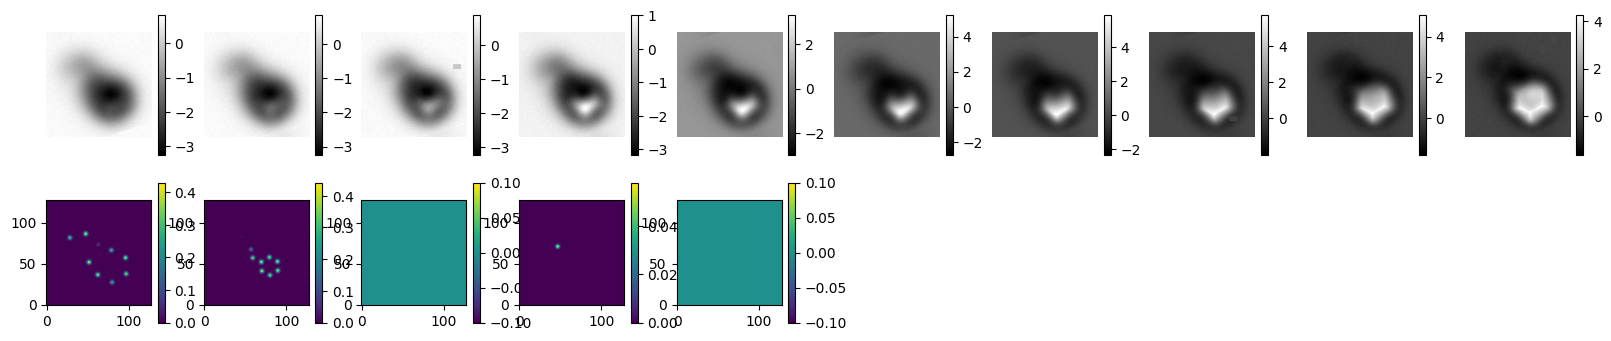

In [17]:
fig = plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    im = plt.imshow(x[..., i, 0], origin='lower', cmap='gray')
    plt.colorbar(im)
    ax.axis('off')

ymax, ymin = y.max(), y.min()
for i in range(5):
    ax = plt.subplot(2, 10, 10 + i + 1)
    im = plt.imshow(y[..., i].mean(axis=-1), origin='lower', vmin=0)
    plt.colorbar(im)

print(ymax, ymin)

Total mean = -5.20e-03, std = 9.98e-01


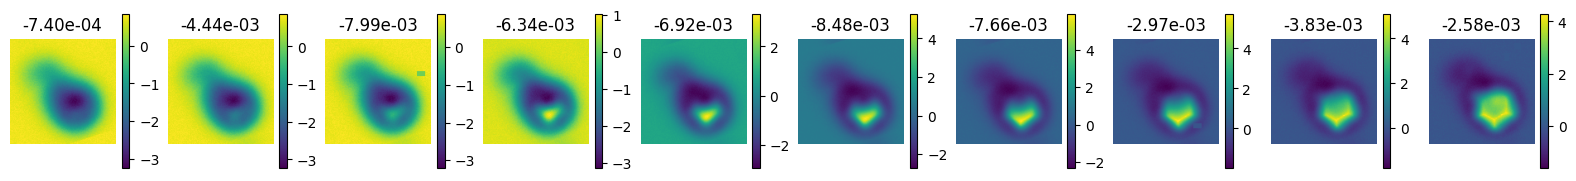

In [18]:
ncols = 10
nrows = x.shape[-2] // ncols
fig = plt.figure(figsize=(ncols * 2, nrows * 2))

for i in range(x.shape[-2]):
    ax = plt.subplot(nrows, ncols, i + 1)
    im = ax.imshow(x[..., i, 0], origin='lower')
    x_mean = x[..., i, 0].mean()
    x_std = x[..., i, 0].std()
    plt.title(f"{x_mean:.2e}")
    plt.axis('off')
    plt.colorbar(im)

print(f"Total mean = {x.mean():.2e}, std = {x.std():.2e}")

In [20]:
for i in range(x.shape[-2]):
    ax = plt.subplot(111)
    im = ax.imshow(x[..., i, 0], origin='lower', cmap='gray')
    plt.axis('off')
    plt.colorbar(im)

    # save the figure in a new directory 
    save_dir = "figures"
    os.makedirs(save_dir, exist_ok=True)

    plt.savefig(os.path.join(save_dir, f"image_{i:02}.png"))
    plt.close()


ymin, ymax: 0.0, 0.9773055911064148


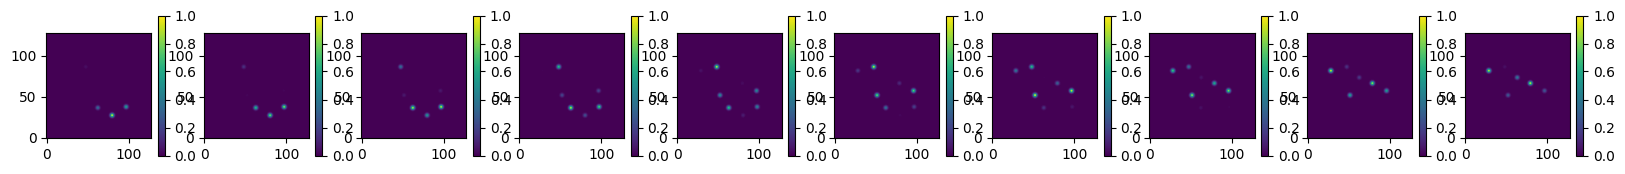

In [19]:
# Plot entire stack of y[..., -1]
channel = 0
ymin, ymax = y.min(), y.max()
print(f"ymin, ymax: {ymin}, {ymax}")

fig = plt.figure(figsize=(20, 4))
for i in range(y.shape[-2]):
    ax = plt.subplot(2, 10, i + 1)
    im = plt.imshow(y[..., i, channel], origin='lower', vmin=0, vmax=1)
    plt.colorbar(im)


In [9]:
mol = ase.Atoms(positions=xyz[:, :3], numbers=xyz[:, -1].astype(int))
print(mol.positions, mol.numbers)
view(mol)

[[ 9.89937305  9.00261593  0.20468192]
 [ 7.27262783  5.62976551 -0.9798798 ]
 [ 6.41110849  9.67715549 -0.28926399]
 [ 4.57469273  8.2787838  -1.15465677]
 [ 5.21709156  8.91747093  0.07314254]
 [ 6.58714104  4.71659231 -0.06983925]
 [11.25216484  8.27976036  2.19047952]
 [ 7.13908148 10.21460915  0.85621423]
 [ 5.46232986  3.96711206 -0.7771225 ]
 [10.99444389  9.34074974  1.12071276]
 [ 8.38021278 11.00011253  0.42314681]
 [ 9.12575054  7.20948696 -1.38143587]
 [ 9.35634422 10.20007706 -0.44961724]
 [10.30116749  7.99314117 -0.78459686]
 [ 8.40653896  6.31967735 -0.36911175]
 [10.34345436  8.10107231  2.78706551]
 [ 7.60798645  5.0942955  -1.78508079]
 [ 6.13419724 10.44888115 -0.90188175]
 [ 6.17020512  5.31758595  0.7585445 ]
 [ 7.28237057  3.984622    0.40439966]
 [ 4.73749924  4.6707592  -1.21617937]
 [ 5.53069687  8.1243515   0.77486193]
 [ 5.85643578  3.33583164 -1.5931406 ]
 [ 4.92830849  3.30518198 -0.0767281 ]
 [ 4.2927413   9.04285812 -1.90069294]
 [11.56542015  7.31584501

<Popen: returncode: None args: ['/u/79/kurkil1/unix/.venvs/tf-2.13/bin/pytho...>

## Create "fake" webdataset for testing

In [ ]:
import webdataset as wds

In [ ]:
def generator(N=100):
    for i in range(N):
        sample = {
            "__key__": str(i*100),
            "label.cls": i*100,
        }
        yield sample

In [ ]:
temp_outputdir = "./temp/shard_1.tar"

os.makedirs(os.path.dirname(temp_outputdir), exist_ok=True)

gen = generator(100)
with wds.TarWriter(temp_outputdir) as sink:
    for sample in gen:
        sink.write(sample)

In [ ]:
shardlist = [
    os.path.join("./temp", shard) for shard in os.listdir("./temp")
]
ds = wds.DataPipeline(
    wds.SimpleShardList(shardlist),

    wds.shuffle(100),

    wds.tarfile_to_samples(),

    wds.shuffle(1000),

    wds.decode("l"),

    wds.to_tuple("__key__", "label.cls"),

    wds.batched(16)
)

In [ ]:
loader = iter(ds)
end_after_this_iteration = False

for i in range(1000):
    try:
        batch = next(loader)
    except StopIteration:
        if end_after_this_iteration:
            break
        print()

        loader = iter(ds)
        end_after_this_iteration = True
        continue

    print(batch[0])

['8900', '2100', '2000', '7300', '1', '6000', '6700', '400', '2800', '3', '1000', '12', '10', '7600', '2500', '27']
['3000', '6600', '22', '2300', '23', '31', '5600', '15', '24', '7700', '9100', '9', '7000', '18', '7800', '9500']
['1900', '46', '66', '3300', '62', '11', '72', '71', '36', '6800', '57', '33', '4600', '7', '4400', '8100']
['9800', '14', '8800', '5700', '1800', '3700', '47', '2600', '600', '6100', '2700', '21', '97', '43', '68', '7200']
['5800', '800', '3900', '8400', '80', '1600', '83', '51', '37', '7400', '6900', '1700', '4900', '87', '1300', '63']
['4300', '30', '9200', '2', '94', '9000', '8700', '95', '52', '7100', '2900', '38', '4', '300', '3600', '73']
['1200', '45', '6200', '100', '39', '49', '13', '4200', '65', '2200', '4500', '85', '5', '7900', '40', '8200']
['86', '9600', '61', '55', '4700', '89', '8600', '19', '76', '77', '3100', '75', '17', '48', '4000', '9900']
['6500', '5200', '8500', '4800', '29', '5900', '69', '34', '3200', '32', '58', '70', '7500', '0', '3

## test tf atom map computation

In [31]:
def compute_map(xyz, sigma=0.2):
    x = tf.linspace(tf.constant(0, dtype=tf.float32), 16, 128)
    y = tf.linspace(tf.constant(0, dtype=tf.float32), 16, 128)
    z = tf.range(14, 16, 0.1, dtype=tf.float32)

    X, Y, Z = tf.meshgrid(x, y, z, indexing='xy')

    # Compute atom maps.
    maps_h = tf.zeros_like(X)
    maps_c = tf.zeros_like(X)
    maps_n = tf.zeros_like(X)
    maps_o = tf.zeros_like(X)
    maps_f = tf.zeros_like(X)

    for atom in xyz:
        if atom[-1] == 1:
            maps_h += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 6:
            maps_c += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 7:
            maps_n += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 8:
            maps_o += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 9:
            maps_f += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )

    atom_map = tf.stack([maps_h, maps_c, maps_n, maps_o, maps_f], axis=0)
    atom_map = tf.transpose(atom_map, perm=[1, 2, 3, 0])
    return atom_map


In [32]:
xyz = tf.random.uniform((xyz.shape[0], 3), 0, 16)
species = tf.random.uniform(xyz.shape, 6, 10, dtype=tf.int32)
species = tf.cast(species, tf.float32)[:,0][..., None]
xyz = tf.concat([xyz, species], axis=-1)

m = compute_map(xyz)

(128, 128, 20, 5)


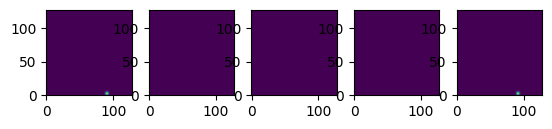

In [36]:
print(m.shape)

for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(m[..., -i, -1], origin='lower')

## data augmentation

In [2]:
def plot_stack(x):
    xmax = tf.reduce_max(x).numpy()
    fig, ax = plt.subplots(1, 5)
    for i in range(5):
        ax[i].imshow(x[..., i, 0], vmin=0, vmax=xmax)

In [6]:
x = np.arange(128)
y = np.arange(128)

x, y = np.meshgrid(x, y)
z = x + y
z = z[..., None]
z = np.tile(z, (1, 1, 5))

z2 = x * y
z2 = z2[None, ..., None]
z2 = np.tile(z2, (5, 1, 1, 20))

orig_batch = {
    "images": z,
    "atom_map": z2,
    "xyz": np.zeros((5, 20, 3)),
}

print(orig_batch['images'].shape)
print(orig_batch['atom_map'].shape)

(128, 128, 5)
(5, 128, 128, 20)


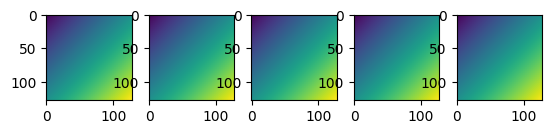

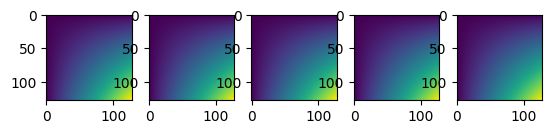

In [7]:
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(z[..., i])

fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(z2[i, ..., 0])

In [16]:
print(orig_batch['images'].shape)

batch = input_pipeline._preprocess_images(
    orig_batch,
    noise_std=0.1,
    interpolate_z=16,
    cutout_probs=[0.5, 0.3, 0.1, 0.05, 0.5],
)

print(orig_batch['images'].shape)

print(batch['images'].shape)
print(batch['atom_map'].shape)

(128, 128, 5)
(128, 128, 5)
(128, 128, 16, 1)
(128, 128, 16, 5)


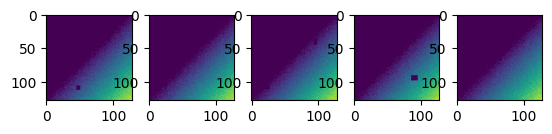

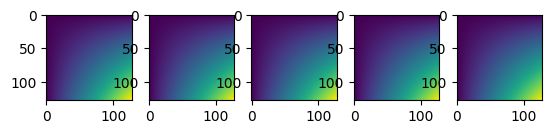

In [17]:
plot_stack(batch['images'])
plot_stack(batch['atom_map'])